# *SDS_Benchmark*: Effect of wave setup correction

(Work in progress)

Here we evaluate the effect of including a wave setup correction when tidally-correcting the SDS time-series for CoastSat, SHOREX and CASSIE (the other algorithms are composites).

When running this notebook you will compare all the submitted time-series, the plots showing the comparisons and reporting the accuracy metrics are saved under **/evaluation/wave_correction**. You can visualise each individual transect under **/evaluation/wave_correction**

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `pytz`.
For the runup calcualtions you will also need  `py-wave-runup`, which can be installed with `pip install py-wave-runup`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [25]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import gridspec
import colorcet as cc
from matplotlib.cm import get_cmap
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
import string

# import utils module located in the repository (utils.py)
import utils

# import py_wave_runup models
from py_wave_runup import models


plt.ion()
letters = string.ascii_lowercase

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.getcwd(),'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt','CALAMILLOR']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
    for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

# filepaths to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission','team_Deltares','team_UQMAO']]
submissions = [submissions[_] for _ in [1,2,0]]
print('\nSubmitted shorelines: %s'%submissions)
labels = {'team_CoastSat':'CoastSat',
          'team_SHOREX':'SHOREX',
          'team_Deltares':'ShorelineMonitor',
          'team_CASSIE':'CASSIE',
          'team_UQMAO':'HighTide-SDS',}

# folder where to save all the figures and outputs
fp_eval =  os.path.join(os.getcwd(),'evaluation')
if not os.path.exists(fp_eval): os.makedirs(fp_eval)

# select contour
contour = 'MSL'
groundtruth_type = 'groundtruth_%s'%contour
print(contour)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Benchmark datasets available:
['DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}
CALAMILLOR: {'beach_slope': 0.1, 'contour_level': 0, 'epsg': 2062}

Submitted shorelines: ['team_CoastSat', 'team_SHOREX', 'team_CASSIE']
MSL


#### Apply wave setup correction to existing time-series

In [26]:
fp_eval_contour =  os.path.join(fp_eval,'wave_correction_%s'%contour)
if not os.path.exists(fp_eval_contour): os.makedirs(fp_eval_contour)
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],}
# make wave corrections
fn_wavecor = os.path.join(fp_eval_contour,'submissions_%s_Landsat_wavecor.pkl'%contour)
if os.path.exists(fn_wavecor):
    with open(fn_wavecor,'rb') as f:
        sub_output = pickle.load(f)
    print('Loaded wave corrections for Landsat')
else:
    # load Landsat data
    fn_output = os.path.join(fp_eval,'Landsat_vs_S2_%s'%contour,'submissions_Landsat_%s.pkl'%contour)
    with open(fn_output,'rb') as f:
        sub_output = pickle.load(f)
    # loop through sites and calculate runup
    for i,sitename in enumerate(names_datasets):
        print(sitename)
        data_folder = os.path.join('datasets',sitename)
        # load wave time-series
        fn_waves = os.path.join(data_folder, sitename + '_waves_ERA5.csv')
        wave_data = pd.read_csv(fn_waves, parse_dates=['dates'])
        dates_ts = [_.to_pydatetime() for _ in wave_data['dates']]
        wave_params = {'swh':[],'mwd':[],'pp1d':[]}
        for key in wave_params.keys():
            wave_params[key] = list(wave_data[key])
            idx_str = np.where([isinstance(_,str) for _ in wave_params[key] ])[0]
            for i in idx_str:
                wave_params[key][i] = (float(wave_params[key][i].split('[')[-1].split(']')[0]))
            wave_params[key] = np.array(wave_params[key]) 
        print('Loaded wave time-series')
        # get beach slope and calculate Stockdon runup
        beach_slope = sites_info[sitename]['beach_slope']
        model_sto06 = models.Stockdon2006(Hs=wave_params['swh'], Tp=wave_params['pp1d'],
                                          beta=beach_slope*np.ones(len(wave_params['swh'])))
        # other runup models
        # model_sen11 = models.Senechal2011(Hs=wave_params['swh'], Tp=wave_params['pp1d'],
        #                                   beta=beach_slope*np.ones(len(wave_params['swh']))) 
        
        # # plot wave time-series
        # fig, ax = plt.subplots(3,1,figsize=(10,8), tight_layout=True)
        # ax[0].grid(which='major', linestyle=':', color='0.5')
        # ax[0].plot(dates_ts, wave_params['swh'], '-',lw=1)
        # ax[0].axhline(y=np.nanmean(wave_params['swh']),ls='--',c='r',lw=1,label='mean Hs = %.1f'%np.nanmean(wave_params['swh']))
        # ax[0].set(ylabel='Hsig [m]',title='ERA5 wave time-series at %s'%sitename)
        # ax[0].legend(loc='upper left')
        # ax[1].grid(which='major', linestyle=':', color='0.5')
        # ax[1].plot(dates_ts, wave_params['pp1d'], '-',lw=1)
        # ax[1].axhline(y=np.nanmean(wave_params['pp1d']),ls='--',c='r',lw=1,label='mean Hs = %.1f'%np.nanmean(wave_params['pp1d']))
        # ax[1].set(ylabel='Tp [s]')
        # ax[1].legend(loc='upper left')
        # ax[2].grid(which='major', linestyle=':', color='0.5')
        # ax[2].plot(dates_ts, wave_params['mwd'], '-',lw=1)
        # ax[2].set(ylabel='Wdir [deg]')
        # print('Plotted wave time-series')
        
        # apply the wave-setup correction to the time-series
        transects = selected_transects[sitename]
        for sub in submissions:
            print(sub)
            for k,key in enumerate(transects):
                print(key)
                # get wave data that matches the satellite data
                dates_sat = sub_output[sub][sitename][key]['dates']
                chain = sub_output[sub][sitename][key]['chainage']
                w_sat = utils.get_closest_datapoint(dates_sat, dates_ts, model_sto06.setup)
                # apply correction
                correction = w_sat/beach_slope
                chain_corrected = chain + correction
                sub_output[sub][sitename][key]['sto06'] = chain_corrected
                print('\n')
    # save as pickle file
    with open(fn_wavecor,'wb') as f:
        pickle.dump(sub_output,f)
    print('Created wave corrections for Landsat...')

Loaded wave corrections for Landsat


#### Compute horizontal errors

In [19]:
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }

# check if file exists
fn_errors = os.path.join(fp_eval_contour,'errors_wavecorr_%s.pkl'%contour)
if os.path.exists(fn_errors):
    # load output_eval pickle    
    with open(fn_errors,'rb') as f:
        output_eval = pickle.load(f)  
    print('Loaded errors dict...')    
else:
    # initialise dict
    output_eval = {}
    # loop through sites
    for sitename in names_datasets:
        output_eval[sitename] = {}
        # get selected transects
        transects = selected_transects[sitename]
        # get groundtruth
        gt = sub_output[groundtruth_type][sitename]
        # make plot comparing the time-series
        fig = plt.figure(figsize=[10,8], tight_layout=True)
        gs = gridspec.GridSpec(len(submissions),1)
        gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            fp_save = os.path.join(fp_eval_contour,'transects',sitename,sub)
            if not os.path.exists(fp_save): os.makedirs(fp_save)
            # evaluate the time-series along each transect
            chain_sat_all, chain_sur_all, satnames_all = [], [], []
            chain_sat_all_dm, chain_sur_all_dm = [], []
            chain_wcor_all,  chain_wcor_all_dm = [], []
            for key in transects:
                if key not in sub_output[sub][sitename].keys(): continue
                if key not in gt.keys(): continue
                ddict = {'dates':sub_output[sub][sitename][key]['dates'],
                         'chainage':sub_output[sub][sitename][key]['chainage'],
                         'satname':sub_output[sub][sitename][key]['satname']}
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries2(ddict,gt,key,settings)
                _.savefig(os.path.join(fp_save,'%s.jpg'%key))
                plt.close(_)
                chain_sat_all = np.append(chain_sat_all,ts_sat)
                chain_sur_all = np.append(chain_sur_all,ts_sur)
                satnames_all = satnames_all + satnames 
                # add demeaned time-series for calculating R2
                chain_sat_all_dm = np.append(chain_sat_all_dm,ts_sat-np.nanmean(ts_sat))
                chain_sur_all_dm = np.append(chain_sur_all_dm,ts_sur-np.nanmean(ts_sur))
                
                # add wave corrections
                ddict = {'dates':sub_output[sub][sitename][key]['dates'],
                         'chainage':sub_output[sub][sitename][key]['sto06'],
                         'satname':sub_output[sub][sitename][key]['satname']}
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries2(ddict,gt,key,settings)
                _.savefig(os.path.join(fp_save,'%s_wavecorr.jpg'%key))
                plt.close(_)
                chain_wcor_all = np.append(chain_wcor_all,ts_sat)
                chain_wcor_all_dm = np.append(chain_wcor_all_dm,ts_sat-np.nanmean(ts_sat))

            # store matching points in dict
            output_eval[sitename][sub] = {'chain_sat':chain_sat_all,
                                          'chain_gt':chain_sur_all,
                                          'satnames':satnames_all,
                                          'wcorr': chain_wcor_all,
                                          'chain_sat_dm':chain_sat_all_dm,
                                          'chain_gt_dm':chain_sur_all_dm,
                                          'wcorr_dm':chain_wcor_all_dm}

            # calculate statistics tide-only time-series
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all_dm, chain_sat_all_dm)
            R2 = rvalue**2
            # store in dict
            output_eval[sitename][sub]['R2'] = R2
            # calculate statistics tide + wave setup time-series
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all_dm, chain_wcor_all_dm)
            R2 = rvalue**2
            # store in dict
            output_eval[sitename][sub]['R2_wcorr'] = R2
    
    # save output_eval as pickle    
    with open(fn_errors,'wb') as f:
        pickle.dump(output_eval,f)
    print('Generated errors dict...')

Generated errors dict...


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

#### Accuracy assessment

In [20]:
# colorpalette to use for each submission
cmap = get_cmap("cet_glasbey_dark")
# colours = plt.get_cmap('Dark2').colors
colours = cmap(np.arange(10))
colours = colours[[0,1,3]]
# limits of yaxis in shoreline plots
ylims = np.array([-50,50])

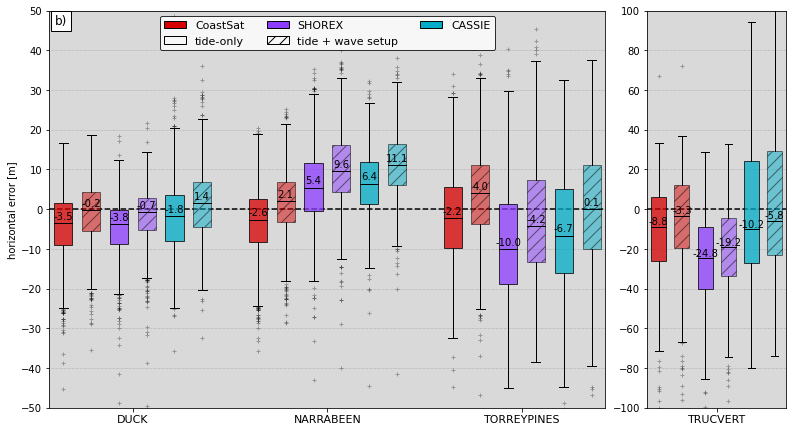

In [21]:
# plot boxplots
factor = 7
# make plot comparing the time-series
fig = plt.figure(figsize=[11.5,6.2], tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
gs.update(left=0.08, right=0.97, bottom=0.06, top=0.95, wspace=0.12)
# axis 1 for DUCK, NARRABEEN, TORREYPINES
ax1 = fig.add_subplot(gs[0])
ax1.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax1.set_facecolor('0.85')
ax1.axhline(y=0, ls='--', lw=1.5, color='k')
ax1.set(ylabel='horizontal error [m]', ylim=[-50,50]);
# axis 2 for TRUCVERT (different y-scale)
ax2 = fig.add_subplot(gs[1])
ax2.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax2.set_facecolor('0.85')
ax2.axhline(y=0, ls='--', lw=1.5, color='k')
ax2.set(ylim=[-100,100])
submissions_short = [_.split('team_')[-1] for _ in submissions]
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        if sitename == 'TRUCVERT': ax = ax2
        else: ax = ax1
        for l,w in enumerate(['chain_sat','wcorr']):
            if w == 'chain_sat': 
                hatch = ''
                alpha = 0.75
            else:                
                hatch = '//'
                alpha = 0.5      
            # compute errors
            chain_error = output_eval[sitename][sub][w] - output_eval[sitename][sub]['chain_gt']
            # plot boxplot
            bp = ax.boxplot(chain_error,sym='+',positions=[(i)*factor+k*2+l],
                            widths=0.65,patch_artist=True,showfliers=True,
                            whiskerprops={'linewidth':1},
                            flierprops={'alpha':0.3,'markersize':4,
                                        'color':'0.5'})
            for median in bp['medians']:
                median.set(color='k', linewidth=1)
            for j,boxes in enumerate(bp['boxes']):
                boxes.set(facecolor=colours[k],alpha=alpha,hatch=hatch)
            # add median value as text
            ax.text((i)*factor+k*2+l,np.median(chain_error)+1,
                    '%.1f'%np.median(chain_error),
                    horizontalalignment='center', fontsize=10)
# add legend
handles = []
handles.append(mpatches.Patch(color=colours[0],ec='k',label=labels[submissions[0]]))
handles.append(mpatches.Patch(color='None',ec='k',label='tide-only'))
handles.append(mpatches.Patch(color=colours[1],ec='k',label=labels[submissions[1]]))
handles.append(mpatches.Patch(color='None',ec='k',label='tide + wave setup',hatch='//'))
handles.append(mpatches.Patch(color=colours[2],ec='k',label=labels[submissions[2]]))
ax1.legend(handles=handles, loc='upper center', ncol=3, fontsize=11,edgecolor='k');
# set xticklabels
ax1.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets)-1)],labels=names_datasets[:-1]);
ax1.set_xticklabels(names_datasets[:-1],fontweight='normal',fontsize=11);
ax2.set_xticks([(_)*factor+factor/2-1 for _ in [3]],labels=[names_datasets[-1]]);
ax2.set_xticklabels([names_datasets[-1]],fontweight='normal',fontsize=11);
# set yticklabels
ax1.set_yticks(np.arange(-50,50+10,10));
ax2.set_yticks(np.arange(-100,100+20,20));
# add letters
ax1.text(0.01,0.99, letters[1] + ')', 
         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
         ha='left',va='top', transform=ax1.transAxes, fontsize=12,zorder=10)
# save figure
fig.savefig(os.path.join(fp_eval_contour,'4_boxplots_wcorr.jpg'),dpi=500)

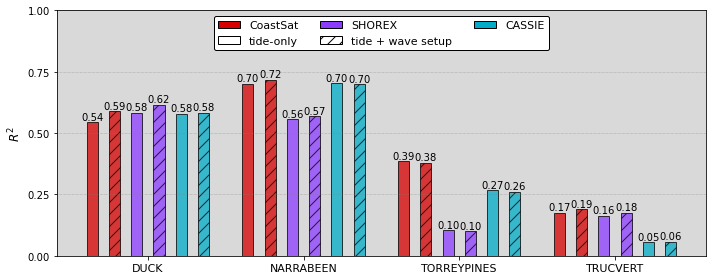

In [22]:
# plot R2
fig,ax = plt.subplots(1,1,figsize=[10,4], tight_layout=True)
ax.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax.set_facecolor('0.85')
ax.set( ylim=[0,1]);
ax.set_ylabel(r'$R^2$',fontsize=12)
# ax.text(0.005,0.98, letters[1] + ')', 
#         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
#         ha='left',va='top', transform=ax3.transAxes, fontsize=14,zorder=10)
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions):
        for l,w in enumerate(['chain_sat','wcorr']):
            if w == 'chain_sat': 
                hatch = ''
                alpha = 0.75
                key = 'R2'
            else:                
                hatch = '//'
                alpha = 0.5
                key = 'R2_wcorr'
            # compute errors
            ax.bar((i)*factor+k*2+l,output_eval[sitename][sub][key],ec='k',fc=colours[k],width=0.5,alpha=0.75,hatch=hatch)
            # add median value as text
            ax.text((i)*factor+k*2+l,output_eval[sitename][sub][key]+0.01,
                    '%.2f'%output_eval[sitename][sub][key],
                    horizontalalignment='center', fontsize=10)
# set xticklabels
ax.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets))],labels=names_datasets);
ax.set_xticklabels(names_datasets,fontweight='normal',fontsize=11);
# set yticklabels
ax.set_yticks(np.arange(0,1+0.25,0.25));
# add legend
handles = []
handles.append(mpatches.Patch(color=colours[0],ec='k',label=labels[submissions[0]]))
handles.append(mpatches.Patch(color='None',ec='k',label='tide-only'))
handles.append(mpatches.Patch(color=colours[1],ec='k',label=labels[submissions[1]]))
handles.append(mpatches.Patch(color='None',ec='k',label='tide + wave setup',hatch='//'))
handles.append(mpatches.Patch(color=colours[2],ec='k',label=labels[submissions[2]]))
ax.legend(handles=handles, loc='upper center', ncol=3, fontsize=11,edgecolor='k',framealpha=1);
fig.savefig(os.path.join(fp_eval_contour,'3_R2_selected.jpg'),dpi=500)

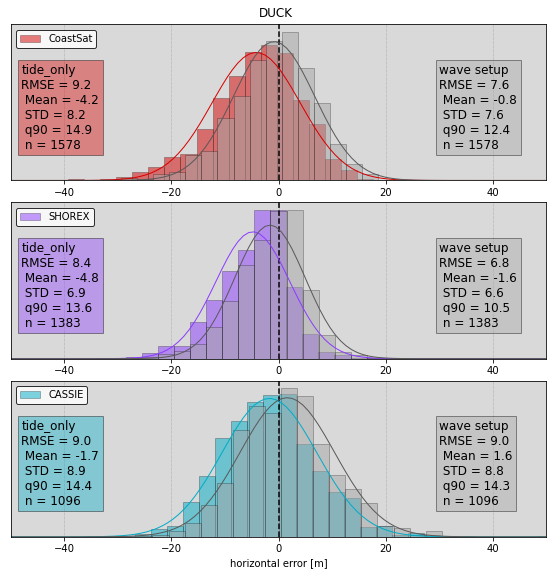

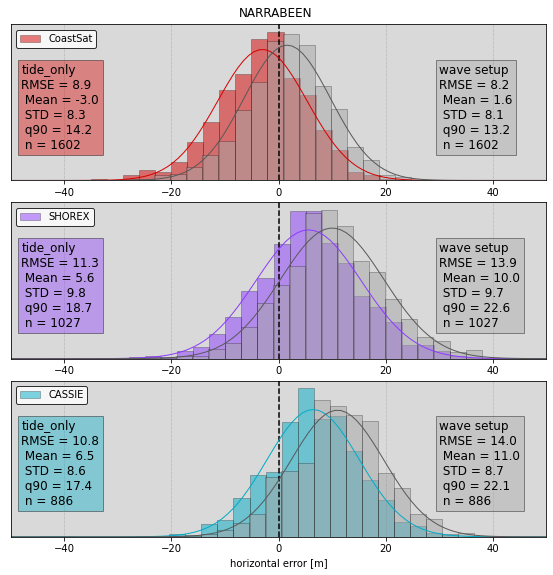

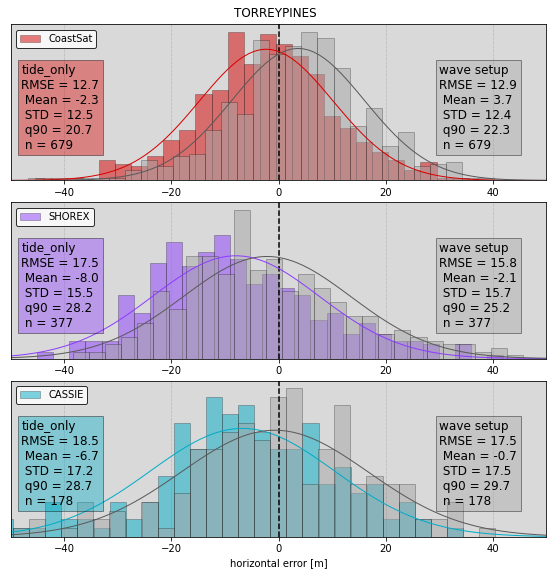

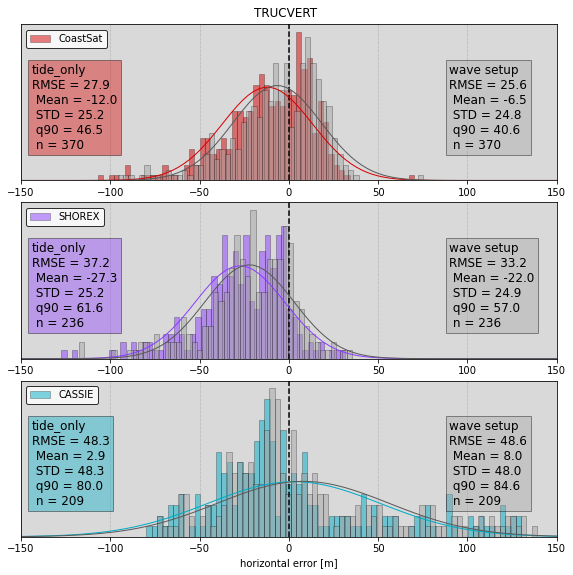

In [23]:
# plot histograms
labels_wcorr = {'chain_sat':'tide_only','wcorr':'wave setup'}
for sitename in names_datasets:
    # make plot comparing the time-series
    fig = plt.figure(figsize=[8,8], tight_layout=True)
    gs = gridspec.GridSpec(len(submissions),1)
    gs.update(left=0.04, right=0.97, bottom=0.06, top=0.95, hspace=0.14)
    fig.suptitle('%s'%(sitename),fontsize=12)
    if sitename == 'TRUCVERT': 
        xlims = [-150,150]
        binwidth = 10
    else:
        xlims = settings['lims']
        binwidth = settings['binwidth']
    # loop through submissions
    for k,sub in enumerate(submissions):
        ax = fig.add_subplot(gs[k,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0) 
        ax.axvline(x=0, ls='--', lw=1.5, color='k')
        binwidth = settings['binwidth']
        ax.set_yticks([])
        ax.set_facecolor('0.85')
        ax.set(xlabel='horizontal error [m]', xlim=xlims)
        for l,w in enumerate(['chain_sat','wcorr']):
            if w == 'chain_sat': 
                hatch = ''
                alpha = 0.75
                key = 'R2'
                xtext = 0.02
                color = colours[k]
            else:                
                hatch = '//'
                alpha = 0.5
                key = 'R2_wcorr'
                xtext = 0.8
                color = '0.65'
            chain_error = output_eval[sitename][sub][w] - output_eval[sitename][sub]['chain_gt']
            # get metrics
            R2 = output_eval[sitename][sub][key]
            rmse = np.sqrt(np.mean((chain_error)**2))
            mean = np.mean(chain_error)
            std = np.std(chain_error)
            q90 = np.percentile(np.abs(chain_error), 90)  
            # plot histogram
            bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
            density = ax.hist(chain_error, bins=bins, density=True, color=color,
                              edgecolor='k',lw=0.5, alpha=0.5, label=labels[sub])
            mu, std = stats.norm.fit(chain_error)
            pval = stats.normaltest(chain_error)[1]
            x = np.linspace(xlims[0], xlims[1], 100)
            p = stats.norm.pdf(x, mu, std)
            if w == 'wcorr':
                ax.plot(x, p, '-',color='0.35', linewidth=1)
            else:
                ax.plot(x, p, '-',color=color, linewidth=1)
            str_stats = '%s\nRMSE = %.1f\n Mean = %.1f\n STD = %.1f\n q90 = %.1f\n n = %d'%(labels_wcorr[w],rmse, mean, std, q90, len(chain_error))
            ax.text(xtext, 0.75, str_stats,va='top', transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle="square", ec='k',fc=color,alpha=0.4))
            if w == 'chain_sat':
                ax.legend(loc=[0.01,0.85],edgecolor='k')

    fig.savefig(os.path.join(fp_eval_contour,'2_%s_histograms.jpg'%sitename),dpi=500)

In [24]:
selected_transects = {
    'NARRABEEN': ['PF8'],
    'DUCK':      ['1097'],
    'TRUCVERT':   ['-400',],
    'TORREYPINES':['PF525'],    
    }
# loop through sites and calculate runup
for i,sitename in enumerate(names_datasets):
    print(sitename)
    data_folder = os.path.join('datasets',sitename)
    # load wave time-series
    fn_waves = os.path.join(data_folder, sitename + '_waves_ERA5.csv')
    wave_data = pd.read_csv(fn_waves, parse_dates=['dates'])
    dates_ts = [_.to_pydatetime() for _ in wave_data['dates']]
    wave_params = {'swh':[],'mwd':[],'pp1d':[]}
    for key in wave_params.keys():
        wave_params[key] = list(wave_data[key])
        idx_str = np.where([isinstance(_,str) for _ in wave_params[key] ])[0]
        for i in idx_str:
            wave_params[key][i] = (float(wave_params[key][i].split('[')[-1].split(']')[0]))
        wave_params[key] = np.array(wave_params[key]) 
    print('Loaded wave time-series')
    # get beach slope and calculate Stockdon runup
    beach_slope = sites_info[sitename]['beach_slope']
    model_sto06 = models.Stockdon2006(Hs=wave_params['swh'], Tp=wave_params['pp1d'],
                                      beta=beach_slope*np.ones(len(wave_params['swh'])))
    print('av. vertical setup: %.2f m'%np.nanmean(model_sto06.setup))
    print('av. horizontal setup: %.1f m'%(np.nanmean(model_sto06.setup)/beach_slope))
    
    # apply the wave-setup correction to the time-series
    transects = selected_transects[sitename]
    for sub in submissions:
        print(sub)
        for k,key in enumerate(transects):
            print(key)
            # get wave data that matches the satellite data
            dates_sat = sub_output[sub][sitename][key]['dates']
            chain = sub_output[sub][sitename][key]['chainage']
            w_sat = utils.get_closest_datapoint(dates_sat, dates_ts, model_sto06.setup)
            # apply correction
            correction = w_sat/beach_slope
            print('av. horizontal correction: %.1f m'%np.nanmean(correction))
            print('\n')

DUCK
Loaded wave time-series
av. vertical setup: 0.33 m
av. horizontal setup: 3.3 m
team_CoastSat
1097
Extracting closest points: 100%av. horizontal correction: 3.2 m


team_SHOREX
1097
Extracting closest points: 100%av. horizontal correction: 3.1 m


team_CASSIE
1097
Extracting closest points: 100%av. horizontal correction: 3.3 m


NARRABEEN
Loaded wave time-series
av. vertical setup: 0.46 m
av. horizontal setup: 4.6 m
team_CoastSat
PF8
Extracting closest points: 100%av. horizontal correction: 4.6 m


team_SHOREX
PF8
Extracting closest points: 100%av. horizontal correction: 4.5 m


team_CASSIE
PF8
Extracting closest points: 100%av. horizontal correction: 4.4 m


TORREYPINES
Loaded wave time-series
av. vertical setup: 0.27 m
av. horizontal setup: 6.0 m
team_CoastSat
PF525
Extracting closest points: 100%av. horizontal correction: 6.0 m


team_SHOREX
PF525
Extracting closest points: 100%av. horizontal correction: 6.0 m


team_CASSIE
PF525
Extracting closest points: 100%av. horizontal cor